In [2]:
import datetime
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import KernelPCA
import numpy as np
import pandas as pd
import math
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
tf.random.set_seed(99)

In [3]:
# Dataset loading
dataFrame = pd.read_csv('/content/drive/MyDrive/Python Projects/My Projects/Basic LSTM Model - Time Series/final_data_adj.csv')  # https://github.com/SusmitSekharBhakta/Stock-market-price-prediction/blob/main/final_data_adj.csv

In [4]:
dataFrame

,Date,Open,High,Low,Close,Adj Close,Volume,RSI,MACD,MACDsig,MACDhist,SMA,CCI,Aroon Up,Aroon Down,Sadj
0,2017-08-28,9907.150391,9925.750000,9882.000000,9912.799805,9912.799805,159600.0,55.406997,28.647258,28.317577,0.515867,12759.905212,24.363507,0.000000,0.000000,NaN
1,2017-08-29,9886.400391,9887.349609,9783.750000,9796.049805,9796.049805,173300.0,55.406997,28.647258,28.317577,0.515867,12759.905212,24.363507,0.000000,0.000000,162.055635
2,2017-08-30,9859.500000,9909.450195,9850.799805,9884.400391,9884.400391,157800.0,55.406997,28.647258,28.317577,0.515867,12759.905212,24.363507,0.000000,0.000000,-22.453545
3,2017-08-31,9905.700195,9925.099609,9856.950195,9917.900391,9917.900391,327700.0,55.406997,28.647258,28.317577,0.515867,12759.905212,24.363507,0.000000,0.000000,-9.197608
4,2017-09-01,9937.650391,9983.450195,9909.849609,9974.400391,9974.400391,157800.0,55.406997,28.647258,28.317577,0.515867,12759.905212,24.363507,0.000000,0.000000,5259.919641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1820,2022-08-22,17682.900391,17690.050781,17467.349609,17490.699219,17490.699219,287600.0,53.212894,208.974422,276.509693,-67.535270,17407.845204,-30.373314,0.785714,0.071429,645.590963
1821,2022-08-23,17357.349609,17625.550781,17345.199219,17577.500000,17577.500000,285600.0,57.211306,187.134510,258.634656,-71.500146,17438.412435,-51.317372,0.714286,1.000000,2362.044621
1822,2022-08-24,17525.449219,17623.650391,17499.250000,17604.949219,17604.949219,262000.0,58.421409,170.080561,240.923837,-70.843276,17470.877409,-32.282705,0.642857,0.928571,4274.279466
1823,2022-08-25,17679.000000,17726.500000,17487.449219,17522.449219,17522.449219,230200.0,53.522099,148.199769,222.379023,-74.179254,17505.497396,-37.494292,0.571429,0.857143,3167.759103


# Data preprocessing
Using the following code, we will preprocess the data by handling missing values, dropping irrelevant columns, scaling features, and scaling target variables, preparing it for the further analysis or modeling.

In [5]:
imputer = SimpleImputer(missing_values=np.nan)  # Handling missing values

dataFrame.drop(columns=['Date'], inplace=True)

dataFrame = pd.DataFrame(imputer.fit_transform(dataFrame), columns=dataFrame.columns)

dataFrame = dataFrame.reset_index(drop=True)

# Applying feature scaling
scaler = MinMaxScaler(feature_range=(0, 1))

df_scaled = scaler.fit_transform(dataFrame.to_numpy())

df_scaled = pd.DataFrame(df_scaled, columns=list(dataFrame.columns))

target_scaler = MinMaxScaler(feature_range=(0, 1))

df_scaled[['Open', 'Close']] = target_scaler.fit_transform(dataFrame[['Open', 'Close']].to_numpy())

df_scaled = df_scaled.astype(float)

#Data preparation
A function called singleStepSampler is introduced to facilitate the preparation of the dataset for single-step time-series forecasting.

This function takes two parameters: a dataframe, denoted as df, and a specified window size. Within the function, two lists, namely xRes and yRes, are initialized to serve as containers for input features and target values, respectively. The function utilizes two nested loops to iterate over the rows of the dataframe, creating sequences of input features (xRes) and corresponding target values (yRes) based on the provided window size. The input features are structured as a sequence of windowed data points, where each data point is a list containing values from every column of the dataframe. Target values, sourced from the 'Open' and 'Close' columns for each window, are appended to yRes.

Ultimately, the function returns numpy arrays xRes and yRes, encapsulating the prepared input features and target values for subsequent time-series forecasting.

eg if we have 50  rows - then it will create windows[say window size = 10] like 1-10,2-11,3-12,4-13 etc

In [7]:
# Single step dataset preparation
def singleStepSampler(df, window):
    xRes = []
    yRes = []
    for i in range(0, len(df) - window):
        res = []
        for j in range(0, window):
            r = []
            for col in df.columns:
                r.append(df[col][i + j])
            res.append(r)
        xRes.append(res)
        yRes.append(df[['Open', 'Close']].iloc[i + window].values)
    return np.array(xRes), np.array(yRes)

In [8]:
# Dataset splitting
SPLIT = 0.85
(xVal, yVal) = singleStepSampler(df_scaled, 20)
X_train = xVal[:int(SPLIT * len(xVal))]
y_train = yVal[:int(SPLIT * len(yVal))]
X_test = xVal[int(SPLIT * len(xVal)):]
y_test = yVal[int(SPLIT * len(yVal)):]

In [9]:
df_scaled

,Open,High,Low,Close,Adj Close,Volume,RSI,MACD,MACDsig,MACDhist,SMA,CCI,Aroon Up,Aroon Down,Sadj
0,0.199868,0.178737,0.216833,0.211888,0.211888,0.088128,0.573174,0.753954,0.738291,0.504494,0.441765,0.541449,0.000000,0.000000,0.172391
1,0.197958,0.175103,0.207848,0.201145,0.201145,0.095693,0.573174,0.753954,0.738291,0.504494,0.441765,0.541449,0.000000,0.000000,0.167173
2,0.195483,0.177194,0.213980,0.209275,0.209275,0.087134,0.573174,0.753954,0.738291,0.504494,0.441765,0.541449,0.000000,0.000000,0.166825
3,0.199734,0.178675,0.214542,0.212358,0.212358,0.180950,0.573174,0.753954,0.738291,0.504494,0.441765,0.541449,0.000000,0.000000,0.166850
4,0.202674,0.184197,0.219380,0.217557,0.217557,0.087134,0.573174,0.753954,0.738291,0.504494,0.441765,0.541449,0.000000,0.000000,0.176766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1820,0.915392,0.913471,0.910560,0.909233,0.909233,0.158807,0.545954,0.898859,0.961158,0.326830,0.928194,0.461065,0.785714,0.071429,0.168083
1821,0.885435,0.907367,0.899389,0.917220,0.917220,0.157703,0.595558,0.881309,0.945107,0.316479,0.931393,0.430307,0.714286,1.000000,0.171313
1822,0.900904,0.907187,0.913478,0.919746,0.919746,0.144671,0.610570,0.867605,0.929204,0.318194,0.934791,0.458261,0.642857,0.928571,0.174911
1823,0.915033,0.916920,0.912399,0.912154,0.912154,0.127112,0.549790,0.850022,0.912551,0.309485,0.938414,0.450607,0.571429,0.857143,0.172829


In [10]:
len(xVal)

1805

# Defining LSTM model

In this stage, a multivariate Long Short-Term Memory neural network model is crafted using TensorFlow's Keras API. The model is initialized as a sequential model, representing a linear stack of layers. The architecture encompasses an LSTM layer with 200 units, designed to process input sequences with a shape defined by the number of features (columns) in the training data (X_train). To prevent overfitting, a dropout layer is introduced. The output layer is a dense layer with 2 units, aligning with the predicted values for the two predictor variables ('Open' and 'Close'). The activation function for this output layer is set to linear. For training, the model is compiled utilizing mean squared error as the loss function, with Mean Absolute Error (MAE) as metrics for further evaluation. The Adam optimizer is employed to facilitate the training process. The summary() method provides a comprehensive overview of the model's architecture, detailing the number of parameters and layer configurations for enhanced understanding.

In [11]:
multivariate_lstm = keras.Sequential()
multivariate_lstm.add(keras.layers.LSTM(200, input_shape=(X_train.shape[1], X_train.shape[2])))
multivariate_lstm.add(keras.layers.Dropout(0.2))
multivariate_lstm.add(keras.layers.Dense(2, activation='linear'))
multivariate_lstm.compile(loss = 'MeanSquaredError', metrics=['MAE'], optimizer='Adam')
multivariate_lstm.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 200)            │       172,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │           402 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 173,202 (676.57 KB)

 Trainable params: 173,202 (676.57 KB)

 Non-trainable params: 0 (0.00 B)

# Model training

Now ,we will train our model on 20 epochs.

In [12]:
history = multivariate_lstm.fit(X_train, y_train, epochs=20)

Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - MAE: 0.1320 - loss: 0.0352
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - MAE: 0.0397 - loss: 0.0026
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - MAE: 0.0329 - loss: 0.0018
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - MAE: 0.0318 - loss: 0.0017
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - MAE: 0.0277 - loss: 0.0014
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - MAE: 0.0277 - loss: 0.0013
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - MAE: 0.0249 - loss: 0.0011
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - MAE: 0.0264 - loss: 0.0012
Epoch 9/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - MAE: 0.0241 - loss: 0.0010
Epoch 10/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - MAE: 0.0235 - loss: 9.6361e-04
Epoch 11/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - MAE: 0.0222 - loss: 8.3904e-04
Epoch 12/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - MAE: 0.0228 - loss: 9.3376e-04
Epoch 13/20
48/48 ━━━━━━━

# Forecasting

This code segment focuses on visualizing the multivariate time-series forecasting results using an LSTM model. Initially, the dataset is reloaded with the 'Date' column serving as the index. The 'Date' column is converted to a datetime format, and the index is set accordingly. The LSTM model (`multivariate_lstm`) is employed to predict values for the test set (`X_test`). The predictions, along with the actual values (`y_test`), are organized into a DataFrame (`d`). The correct date index is assigned to this DataFrame, aligning it with the original dataset. Subsequently, a plot is created using Matplotlib to showcase the actual and predicted values over time. The actual values for 'Open' and 'Close' are plotted, while the predicted values are represented with dashed lines. Additionally, a portion of the plot is highlighted in a different color, denoted as 'lightgreen', corresponding to the forecasted period. This visual distinction aids in easily identifying the forecasted portion within the overall plot. The resulting plot provides a clear representation of the model's performance, allowing for a visual comparison between predicted and actual values, and highlighting the forecasted period for further analysis.

In [16]:
dataFrame

,Open,High,Low,Close,Adj Close,Volume,RSI,MACD,MACDsig,MACDhist,SMA,CCI,Aroon Up,Aroon Down,Sadj
0,9907.150391,9925.750000,9882.000000,9912.799805,9912.799805,159600.0,55.406997,28.647258,28.317577,0.515867,12759.905212,24.363507,0.000000,0.000000,2935.220856
1,9886.400391,9887.349609,9783.750000,9796.049805,9796.049805,173300.0,55.406997,28.647258,28.317577,0.515867,12759.905212,24.363507,0.000000,0.000000,162.055635
2,9859.500000,9909.450195,9850.799805,9884.400391,9884.400391,157800.0,55.406997,28.647258,28.317577,0.515867,12759.905212,24.363507,0.000000,0.000000,-22.453545
3,9905.700195,9925.099609,9856.950195,9917.900391,9917.900391,327700.0,55.406997,28.647258,28.317577,0.515867,12759.905212,24.363507,0.000000,0.000000,-9.197608
4,9937.650391,9983.450195,9909.849609,9974.400391,9974.400391,157800.0,55.406997,28.647258,28.317577,0.515867,12759.905212,24.363507,0.000000,0.000000,5259.919641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1820,17682.900391,17690.050781,17467.349609,17490.699219,17490.699219,287600.0,53.212894,208.974422,276.509693,-67.535270,17407.845204,-30.373314,0.785714,0.071429,645.590963
1821,17357.349609,17625.550781,17345.199219,17577.500000,17577.500000,285600.0,57.211306,187.134510,258.634656,-71.500146,17438.412435,-51.317372,0.714286,1.000000,2362.044621
1822,17525.449219,17623.650391,17499.250000,17604.949219,17604.949219,262000.0,58.421409,170.080561,240.923837,-70.843276,17470.877409,-32.282705,0.642857,0.928571,4274.279466
1823,17679.000000,17726.500000,17487.449219,17522.449219,17522.449219,230200.0,53.522099,148.199769,222.379023,-74.179254,17505.497396,-37.494292,0.571429,0.857143,3167.759103


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


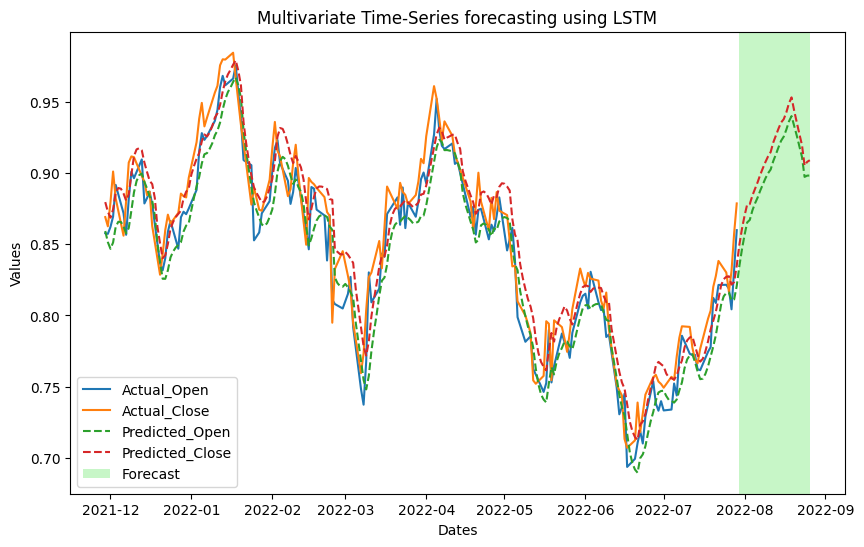

In [17]:
# Dataset loading
dataFrame = pd.read_csv('/content/drive/MyDrive/Python Projects/My Projects/Basic LSTM Model - Time Series/final_data_adj.csv')  # https://github.com/SusmitSekharBhakta/Stock-market-price-prediction/blob/main/final_data_adj.csv

dataFrame['Date'] = pd.to_datetime(dataFrame['Date'])
dataFrame.set_index('Date', inplace=True)

# Forecast Plot with Dates on X-axis
predicted_values = multivariate_lstm.predict(X_test)

d = {
    'Predicted_Open': predicted_values[:, 0],
    'Predicted_Close': predicted_values[:, 1],
    'Actual_Open': y_test[:, 0],
    'Actual_Close': y_test[:, 1],
}

d = pd.DataFrame(d)
d.index = dataFrame.index[-len(y_test):]  # Assigning the correct date index

fig, ax = plt.subplots(figsize=(10, 6))
#  highlight the  forecast
highlight_start = int(len(d) * 0.9)
highlight_end = len(d) - 1  # Adjusted to stay within bounds
# Plot the actual values
plt.plot(d[['Actual_Open', 'Actual_Close']][:highlight_start], label=['Actual_Open', 'Actual_Close'])

# Plot predicted values with a dashed line
plt.plot(d[['Predicted_Open', 'Predicted_Close']], label=['Predicted_Open', 'Predicted_Close'], linestyle='--')

# Highlight the forecasted portion with a different color
plt.axvspan(d.index[highlight_start], d.index[highlight_end], facecolor='lightgreen', alpha=0.5, label='Forecast')

plt.title('Multivariate Time-Series forecasting using LSTM')
plt.xlabel('Dates')
plt.ylabel('Values')
ax.legend()
plt.show()

SyntaxError: unterminated string literal (detected at line 2) (ipython-input-3103385144.py, line 2)

# Model evaluation
Now we will evaluate the model's performance in terms of MSE, MAE and R2-Score for each predictor variable.

In [19]:
# Model Evaluation
def eval(model):
    return {
        'MSE': sklearn.metrics.mean_squared_error(d[f'Actual_{model.split("_")[1]}'].to_numpy(), d[model].to_numpy()),
        'MAE': sklearn.metrics.mean_absolute_error(d[f'Actual_{model.split("_")[1]}'].to_numpy(), d[model].to_numpy()),
        'R2': sklearn.metrics.r2_score(d[f'Actual_{model.split("_")[1]}'].to_numpy(), d[model].to_numpy())
    }

result = dict()

for item in ['Predicted_Open', 'Predicted_Close']:
    result[item] = eval(item)

result

{'Predicted_Open': {'MSE': 0.00024151976246934197,
  'MAE': 0.012085293195679884,
  'R2': 0.941387511789352},
 'Predicted_Close': {'MSE': 0.0003600728844110131,
  'MAE': 0.015187183450502253,
  'R2': 0.9113460418763994}}